In [39]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path 
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [40]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False


In [41]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [42]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [43]:
def getDataPointios(line):
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
        date, time = dateTime.split(',')
    else:
        date, time = dateTime.split(' ')
    message = ' '.join(splitLine[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    if time[5]==":":
        time = time[:5]+time[-3:]
    else:
        if 'AM' in time or 'PM' in time:
            time = time[:6]+time[-3:]
        else:
            time = time[:6]
    return date, time, author, message

In [44]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list



### Data preprocessing to extract useful information from it.

In [45]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'Group.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None #message contains 4 things-"date","time","author","message" 
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line): 
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

19/12/2020, 2:08 pm - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [46]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date','Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        ### Counting number of letters in each message
        df["Letter's"] = df['Message'].apply(lambda s : len(s))
        ### Counting number of word's in each message
        df["Word's"] = df['Message'].apply(lambda s : len(s.strip().split(' ')))
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
        ### Function to count number of media in chat.
        MEDIAPATTERN = r'<Media omitted>'
        df['Media_Count'] = df.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()
        media = np.sum(df.Media_Count)
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        ### Counting number of letters in each message
        df["Letter's"] = df['Message'].apply(lambda s : len(s))
        ### Counting number of word's in each message
        df["Word's"] = df['Message'].apply(lambda s : len(s.split(' ')))
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
        ### Function to count number of media in chat.
        MEDIAPATTERN = r' <Media omitted>'
        df['Media_Count'] = df.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()
        media = np.sum(df.Media_Count)

In [47]:
### Adding one more column of "Day" for better analysis, here we use datetime library which help us to do this task easily.
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}

df["Day"] = df['Date'].dt.weekday.map(weeks)
# Rearrenging the columns for better understanding.
df = df[['Date', 'Day', 'Time','Author','Message', "emoji", "Letter's", "Word's", 'urlcount', 'Media_Count']]
# Change the datatype of the column "Day"
df['Day'] = df['Day'].astype('category')
# Looking newborn dataset
df.head()

,Date,Day,Time,Author,Message,emoji,Letter's,Word's,urlcount,Media_Count
1,2020-02-12,Wednesday,8:20 am,+254 700 458074,Single🤣🤣🤣,"[🤣, 🤣, 🤣]",10,1,0,0
2,2020-02-12,Wednesday,8:53 am,+254 750 352380,😄,[😄],2,1,0,0
3,2020-03-12,Thrusday,11:21 am,Billy Otieno Oracle,"Thanks for sharing, Justin",[],27,4,0,0
4,2020-03-12,Thrusday,1:07 pm,+254 729 048455,Is he still a tech professional or just a pol...,[],63,11,0,0
5,2020-03-12,Thrusday,1:43 pm,+254 777 473495,While I support the petition to stop the ongo...,[],521,85,0,0


In [48]:
df.info() #statistics of the group chat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 1 to 2434
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1141 non-null   datetime64[ns]
 1   Day          1141 non-null   category      
 2   Time         1141 non-null   object        
 3   Author       1141 non-null   object        
 4   Message      1141 non-null   object        
 5   emoji        1141 non-null   object        
 6   Letter's     1141 non-null   int64         
 7   Word's       1141 non-null   int64         
 8   urlcount     1141 non-null   int64         
 9   Media_Count  1141 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(4)
memory usage: 90.6+ KB


In [49]:
df.Author.unique() #returns all unique athors means all members of group

array(['+254 700 458074', '+254 750 352380', 'Billy Otieno Oracle',
       '+254 729 048455', '+254 777 473495', '+254 714 431590',
       'Kenedy Wangari', '+254 726 466456', '+971 50 827 2681',
       '+1 (240) 544-8539', '+254 721 201220', '+254 713 595713',
       '+254 705 882004', '+254 713 559850', '+254 723 775972',
       '+254 720 290673', '+254 710 414566', '+254 713 004327',
       '+254 738 087993', '+254 727 616371', '+254 700 826485',
       '+254 729 791895', '+254 727 130312', '+254 715 876163',
       '+44 7782 453222', '+254 723 160647', '+254 716 101187',
       '+254 723 234656', '+254 735 095477', '+1 (763) 482-9867',
       '+254 713 657732', '+254 718 115635', '+254 726 539253',
       '+254 725 470477', '+254 705 000315', '+254 714 120488',
       '+254 770 246132', '+254 719 641539', 'Eliud Choge',
       '+254 726 895167', '+254 729 035475', '+254 737 907554',
       '+254 713 541258', '+254 715 193822', '+254 701 839693',
       '+254 790 606342', '+254 700 

In [50]:
df = df.dropna() #drops all null values
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 1 to 2434
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1141 non-null   datetime64[ns]
 1   Day          1141 non-null   category      
 2   Time         1141 non-null   object        
 3   Author       1141 non-null   object        
 4   Message      1141 non-null   object        
 5   emoji        1141 non-null   object        
 6   Letter's     1141 non-null   int64         
 7   Word's       1141 non-null   int64         
 8   urlcount     1141 non-null   int64         
 9   Media_Count  1141 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(4)
memory usage: 90.6+ KB


In [51]:
total_messages = df.shape[0]
print(total_messages)

1141


In [52]:
media_messages = df[df['Message'] == r' <Media omitted>'].shape[0]
print(media_messages)

339


In [53]:
left_messages = df[df['Message'] == r"left"].shape[0]
print(left_messages)

0


In [54]:
emojis = sum(df['emoji'].str.len()) 
print(emojis)

416


In [55]:
URLPATTERN = r'(https?://\S+)' #regex pattern matching with start with https
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() #return url which matches with pattern and count it through lambda function
links = np.sum(df.urlcount) #sumup all the links
print(links)


90


Emoji Statistics


In [56]:
total_emojis_list = list(set([a for b in df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

84


Most used Emoji in Group

In [57]:
total_emojis_list = list([a for b in df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,65
1,🤣,21
2,💯,21
3,😊,20
4,😄,16
...,...,...
79,🍇,1
80,🚩,1
81,🌱,1
82,🌍,1


In [58]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [59]:
subset = df.Author.value_counts()
subset[subset > 45].index

Index(['Billy Otieno Oracle', '+254 714 431590', 'Kenedy Wangari',
       '+254 705 882004', '+254 700 826485', 'Eliud Choge WhatsApp'],
      dtype='object')

In [60]:
# Creates a list of top 10 unique Authors 
l = subset[subset > 45].index
for i in range(len(l)):
  dummy_df = df[df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Billy Otieno Oracle


Emoji Distribution for +254 714 431590


Emoji Distribution for Kenedy Wangari


Emoji Distribution for +254 705 882004


Emoji Distribution for +254 700 826485


Emoji Distribution for Eliud Choge WhatsApp


In [61]:
l = df.Day.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Day"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Wednesday   ->   206
Thrusday   ->   167
Sunday   ->   96
Tuesday   ->   196
Friday   ->   183
Saturday   ->   148
Monday   ->   145


In [75]:
" ".join(review for review in df.Message.apply(lambda s: s.strip().split(" ")))

TypeError: sequence item 0: expected str instance, list found

### Extracting basic Statistics of each user.


In [63]:
l = df.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(f'--> Stats of {l[i]} <-- ')
  ### shape will print number of rows which indirectly means the number of messages
  print('Total Message Sent : ', req_df.shape[0])
  ### Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df["Word's"]))/req_df.shape[0]
  w_p_m = ("%.3f" % round(words_per_message, 2))  
  print('Average Words per Message : ', w_p_m)
  ### media conists of media messages
  media = sum(req_df["Media_Count"])
  print('Total Media Message Sent : ', media)
  ### links consist of total links
  links = sum(req_df["urlcount"])   
  print('Total Links Sent : ', links)   
  print()
  print('----------------------------------------------------------n')


--> Stats of +254 700 458074 <-- 
Total Message Sent :  13
Average Words per Message :  13.150
Total Media Message Sent :  1
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of +254 750 352380 <-- 
Total Message Sent :  3
Average Words per Message :  4.670
Total Media Message Sent :  0
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Billy Otieno Oracle <-- 
Total Message Sent :  119
Average Words per Message :  17.620
Total Media Message Sent :  50
Total Links Sent :  21

----------------------------------------------------------n
--> Stats of +254 729 048455 <-- 
Total Message Sent :  26
Average Words per Message :  6.310
Total Media Message Sent :  4
Total Links Sent :  1

----------------------------------------------------------n
--> Stats of +254 777 473495 <-- 
Total Message Sent :  4
Average Words per Message :  23.250
Total Media Message Sent :  1
Total Links Sent :  0

-----------------

Word Cloud- Is a visual representation of words in a particular text. 
The size of words in the wordcloud is directly proportional to the frequency of that word in a text. 

In [78]:
text = " ".join(review for review in df.Message).strip()
print ("There are {} words in all the messages.".format(len(text)))

There are 106272 words in all the messages.


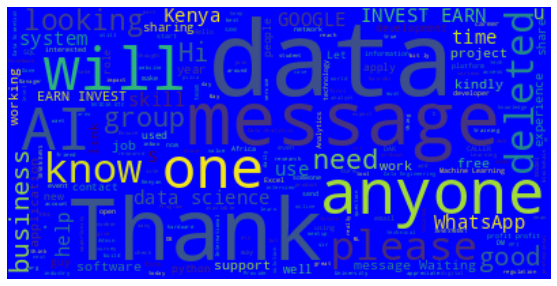

In [65]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "Omitted", "Media", "https", "ani", "em", "ki", "ah","ha","la","eh","ne","le"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="blue").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Number of messages as time moves on

In [66]:
date_df = df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="Word's", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

The Most happening Day was.

In [90]:
df['Date'].value_counts().to_frame().head(10)

,Date
2021-12-01,32
2021-04-23,28
2021-01-20,27
2020-12-19,24
2021-10-04,21
2021-02-21,20
2021-04-29,20
2020-12-14,20
2021-08-17,17
2021-05-19,16


Text(0, 0.5, 'Date')

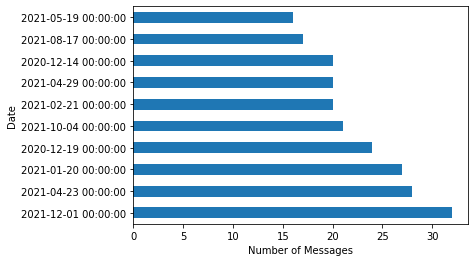

In [67]:
df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Seems like 1st Jaunuary 2021 was the most happening day in the Group.  Over 45 messages on that day. 

# Daywise Distribution.

In [68]:
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(df["Message"])
day_df['day_of_date'] = df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,250]
    )),
  showlegend=False
)
fig.show()

Clearly, we see that  Wednesdays have the highest number of messages, Roughly 200-220. 

# When are the group members most active?

Text(0, 0.5, 'Time')

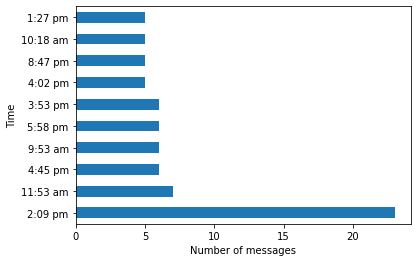

In [69]:
df['Time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('Time')

We can notice that most of the activity in the group was happening around 2.09 pm. 

## Check who is the most active author of the group.

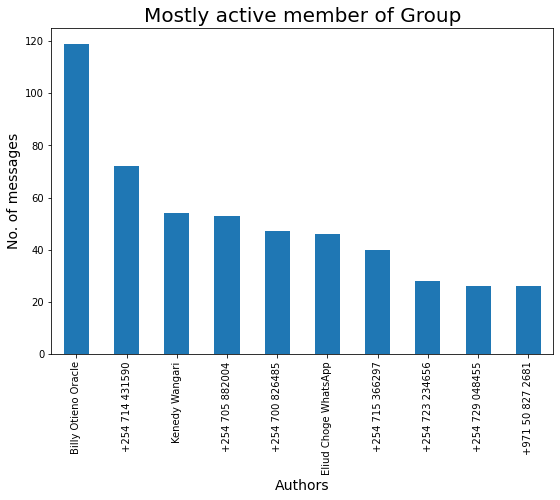

In [70]:
### Mostly Active Author in the Group
plt.figure(figsize=(9,6))
mostly_active = df['Author'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
m_a = mostly_active.head(10)
bars = m_a.index
x_pos = np.arange(len(bars))
m_a.plot.bar()
plt.xlabel('Authors',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Mostly active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()

In [71]:
m_a

Billy Otieno Oracle     119
+254 714 431590          72
Kenedy Wangari           54
+254 705 882004          53
+254 700 826485          47
Eliud Choge WhatsApp     46
+254 715 366297          40
+254 723 234656          28
+254 729 048455          26
+971 50 827 2681         26
Name: Author, dtype: int64

### Most active day in a week:

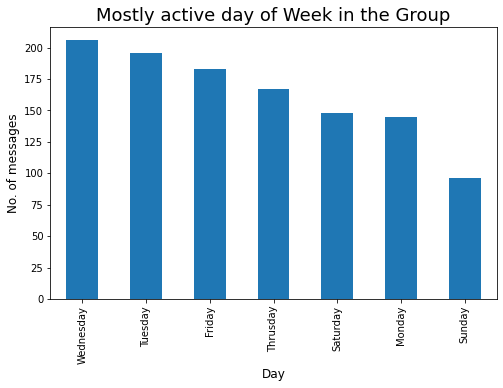

In [72]:
### Mostly Active day in the Group
plt.figure(figsize=(8,5))
active_day = df['Day'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
a_d = active_day.head(10)
a_d.plot.bar()
plt.xlabel('Day',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Mostly active day of Week in the Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

### Let's Check the Top-10 media contributors in the group:

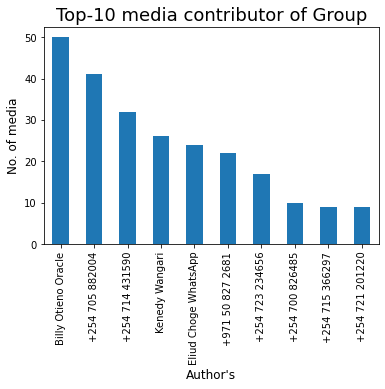

In [73]:
### Top-10 Media Contributor of Group
mm = df[df['Message'] == r' <Media omitted>']
mm1 = mm['Author'].value_counts()
x_pos = np.arange(10)
top10 = mm1.head(10)
bars = top10.index
top10.plot.bar()
plt.xlabel("Author's",fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of media',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Top-10 media contributor of Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()